# EDA

In [1]:
import os

# Path to dataset
dataset_path = "Oily-Dry-Skin-Types"

# List the subdirectories (classes) in train, test, and validate
for split in ['train', 'test', 'valid']:
    split_path = os.path.join(dataset_path, split)
    print(f"{split} classes:")
    print(os.listdir(split_path))
    for class_dir in os.listdir(split_path):
        class_path = os.path.join(split_path, class_dir)
        print(f"{class_dir} has {len(os.listdir(class_path))} images")
    print("\n")


train classes:
['dry', 'normal', 'oily']
dry has 652 images
normal has 1104 images
oily has 1000 images


test classes:
['dry', 'normal', 'oily']
dry has 35 images
normal has 59 images
oily has 40 images


valid classes:
['dry', 'normal', 'oily']
dry has 71 images
normal has 111 images
oily has 80 images




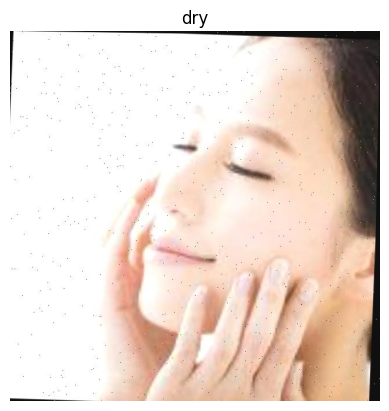

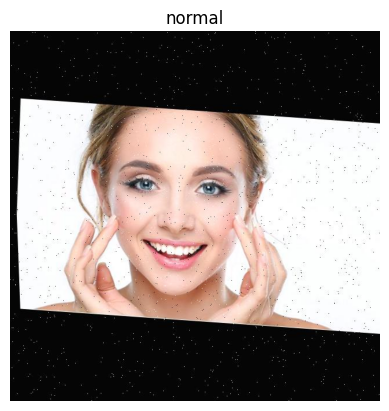

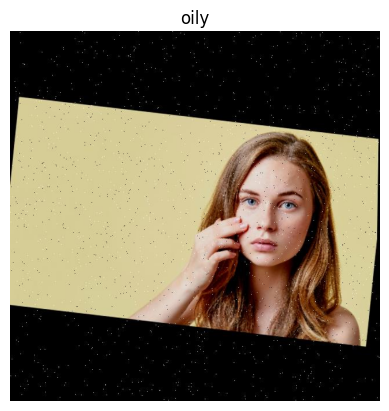

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Visualize random images from each class
def visualize_images(data_dir, classes):
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        random_image = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, random_image)
        img = mpimg.imread(img_path)
        plt.figure()
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

# Specify the path to training images and classes
train_path = "Oily-Dry-Skin-Types/train"
classes = os.listdir(train_path)
visualize_images(train_path, classes)


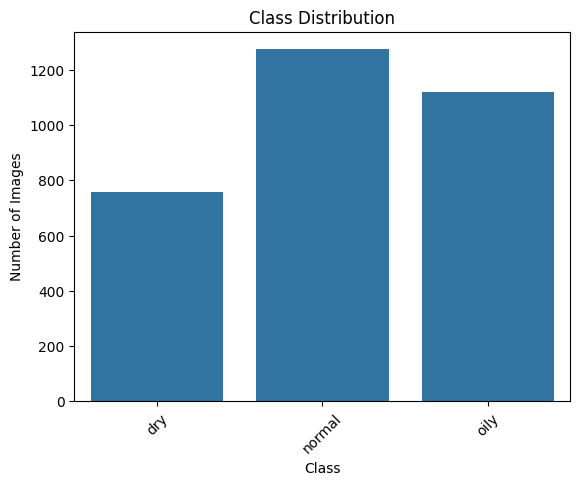

In [4]:
import pandas as pd
import seaborn as sns

# Count the number of images per class
class_counts = {}
for split in ['train', 'test', 'valid']:
    split_path = os.path.join(dataset_path, split)
    for class_dir in os.listdir(split_path):
        class_path = os.path.join(split_path, class_dir)
        if class_dir not in class_counts:
            class_counts[class_dir] = 0
        class_counts[class_dir] += len(os.listdir(class_path))

# Plot the distribution
class_counts_df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Image Count'])
sns.barplot(x=class_counts_df.index, y=class_counts_df['Image Count'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


Image dimensions summary:         Width  Height
count  3152.0  3152.0
mean    640.0   640.0
std       0.0     0.0
min     640.0   640.0
25%     640.0   640.0
50%     640.0   640.0
75%     640.0   640.0
max     640.0   640.0


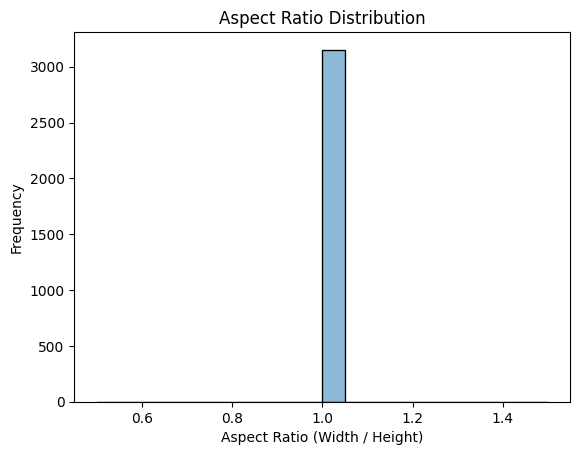

In [5]:
from PIL import Image
import numpy as np

# Analyze image dimensions
image_shapes = []
for split in ['train', 'test', 'valid']:
    split_path = os.path.join(dataset_path, split)
    for class_dir in os.listdir(split_path):
        class_path = os.path.join(split_path, class_dir)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)
            image_shapes.append(img.size)  # Width, Height

# Convert dimensions to numpy array and inspect
image_shapes = np.array(image_shapes)
print(f"Image dimensions summary: {pd.DataFrame(image_shapes, columns=['Width', 'Height']).describe()}")

# Visualize aspect ratio distribution
aspect_ratios = image_shapes[:, 0] / image_shapes[:, 1]
sns.histplot(aspect_ratios, bins=20, kde=True)
plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Frequency")
plt.show()


# Imports

In [6]:
%pip install tensorflow --upgrade


Note: you may need to restart the kernel to use updated packages.


In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ResNet50

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

In [8]:
# Constants
EPOCHS = 20
LR = 0.1
STEP = 15
GAMMA = 0.1
BATCH = 32
OUT_CLASSES = 3
IMG_SIZE = 224
AUTOTUNE = tf.data.AUTOTUNE


In [9]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}

In [10]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)

In [11]:
train_df = create_df("Oily-Dry-Skin-Types/train")
val_df = create_df("Oily-Dry-Skin-Types/valid")
test_df = create_df("Oily-Dry-Skin-Types/test")

In [12]:
train_df = pd.concat([train_df, val_df, test_df])

In [13]:
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [14]:
# Preprocessing function
def preprocess_image(file_path, label):
    # Load and decode the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3) # RGB channels
    
    # Resize the image
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0 #Normalize

    return img, tf.one_hot(label, depth=OUT_CLASSES)


In [15]:
def create_dataset(dataframe, batch_size, shuffle=False):
    file_paths = dataframe.iloc[:, 0].values
    labels = dataframe.iloc[:, 1].values
    
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    
    dataset = dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    return dataset

In [16]:
# Create datasets
train_data = create_dataset(train_df, BATCH, shuffle=True)
val_data = create_dataset(val_df, BATCH)
test_data = create_dataset(test_df, BATCH)


In [17]:
# Load the ResNet50 base model
base_model = ResNet50(
    weights='imagenet',  
    include_top=False,  
    input_shape=(IMG_SIZE, IMG_SIZE, 3) 
)

# Freeze the base model
base_model.trainable = False

# Add custom classifier on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global average pooling instead of Flatten
    layers.Dense(128, activation='relu'),  # Custom dense layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(OUT_CLASSES, activation='softmax'),  # Output layer for classification
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
# Define the learning rate schedule
initial_learning_rate = LR
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=STEP * 100,  
    decay_rate=GAMMA,        
    staircase=True           
)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  
    metrics=['accuracy'],
)


In [20]:
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    #class_weight=class_weight_dict
)


Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.3647 - loss: 12.9280 - val_accuracy: 0.4000 - val_loss: 1.1345
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.4169 - loss: 1.0679 - val_accuracy: 0.4000 - val_loss: 1.0872
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.4139 - loss: 1.2290 - val_accuracy: 0.3333 - val_loss: 1.0952
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.3871 - loss: 1.0783 - val_accuracy: 0.3333 - val_loss: 1.1045
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.3785 - loss: 1.0712 - val_accuracy: 0.4000 - val_loss: 1.1026
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.3766 - loss: 1.0818 - val_accuracy: 0.4000 - val_loss: 1.0910
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4031 - loss: 1.0781 - val_accuracy: 0.4000 - val_loss: 1.1021
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.3877 - loss: 1.0794 - val_accuracy: 0.4000 - val_

In [21]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 964ms/step - accuracy: 0.3380 - loss: 1.1260
Test Accuracy: 36.71%


In [22]:
# Unfreeze some layers of the base model to fine-tune
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tune the model
history_fine_tune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS // 2,
    steps_per_epoch=len(train_data),
    validation_steps=len(val_data)
)


Epoch 1/10


79/79 ━━━━━━━━━━━━━━━━━━━━ 363s 4s/step - accuracy: 0.3090 - loss: 14.3119 - val_accuracy: 0.3968 - val_loss: 1.2424
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 336s 4s/step - accuracy: 0.3662 - loss: 4.7034 - val_accuracy: 0.2667 - val_loss: 5.5785
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 357s 5s/step - accuracy: 0.4423 - loss: 2.0715 - val_accuracy: 0.2667 - val_loss: 9.2393
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 458s 6s/step - accuracy: 0.4793 - loss: 1.2717 - val_accuracy: 0.2667 - val_loss: 7.5359
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 499s 6s/step - accuracy: 0.4766 - loss: 1.0833 - val_accuracy: 0.2667 - val_loss: 6.2001
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 488s 6s/step - accuracy: 0.5228 - loss: 0.9708 - val_accuracy: 0.2698 - val_loss: 5.5891
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 484s 6s/step - accuracy: 0.5285 - loss: 0.9533 - val_accuracy: 0.2762 - val_loss: 5.2344
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 482s 6s/step - accuracy: 0.5557 - loss: 0.9277 - val_accuracy: 0.2730 - val_loss: 5

In [23]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3585 - loss: 2.9780
Test Accuracy: 37.03%


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


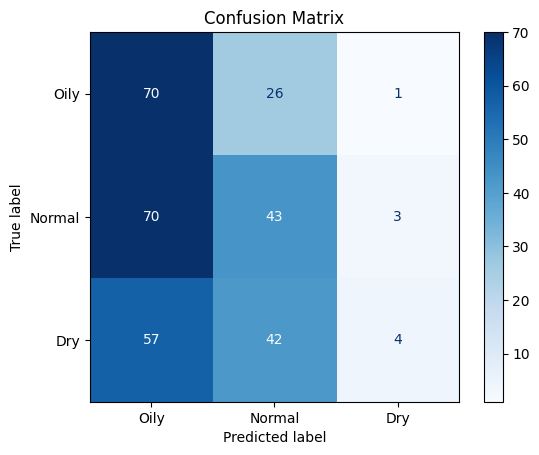

In [24]:
# Get predictions and true labels for the test dataset
y_true = []
y_pred = []

for images, labels in test_data:
    # Get true labels
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    
    # Predict on the images
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Oily", "Normal", "Dry"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [25]:
model.save("resnet50_model.h5")

loaded_model = tf.keras.models.load_model("resnet50_model.h5")

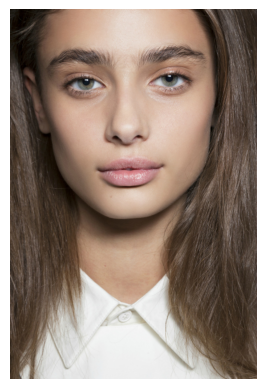

In [26]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

image_path = "dry.jpg"

img = Image.open(image_path)

plt.imshow(img)
plt.axis("off")
plt.show()


In [27]:
import numpy as np

target_size = (224, 224)

img = img.resize(target_size)

img_array = np.array(img)

img_array = img_array / 255.0

img_array = np.expand_dims(img_array, axis=0)

print("Processed image shape:", img_array.shape)


Processed image shape: (1, 224, 224, 3)


In [28]:
model = tf.keras.models.load_model("resnet50_model.h5")
index_label = {0: "dry", 1: "normal", 2: "oily"}

predictions = model.predict(img_array)

predicted_class = tf.argmax(predictions[0]).numpy()
print("Predicted Class:", index_label[predicted_class])



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: normal


# Oily Regions

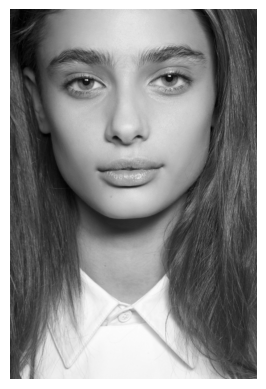

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "dry.jpg"
image = cv2.imread(image_path)

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_image, cmap="gray")
plt.axis("off")
plt.show()


In [3]:
# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_smile.xml")

# Convert the image to gray
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)

# Create a blank mask with the same dimensions as the image
oily_regions_full = np.zeros_like(gray_image)

Oily Density = 10.15%


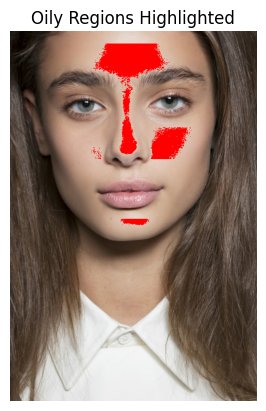

In [5]:
# Extract face region and apply thresholding
for (x, y, w, h) in faces:
    face_roi = gray_image[y:y+h, x:x+w]

    # Create a mask for the face ROI
    face_mask = np.ones_like(face_roi, dtype=np.uint8) * 255

    # Detect eyes in the face ROI
    eyes = eye_cascade.detectMultiScale(face_roi, scaleFactor=1.1, minNeighbors=10)
    for (ex, ey, ew, eh) in eyes:
        face_mask[ey:ey+eh, ex:ex+ew] = 0  # Mask out the eyes region

    # Detect smile in the face ROI
    smiles = smile_cascade.detectMultiScale(face_roi, scaleFactor=1.8, minNeighbors=20)
    for (sx, sy, sw, sh) in smiles:
        face_mask[sy:sy+sh, sx:sx+sw] = 0  # Mask out the smile region

    # Apply the mask to the face ROI
    face_roi_masked = cv2.bitwise_and(face_roi, face_roi, mask=face_mask)

    # Apply thresholding to the masked face region
    _, oily_regions = cv2.threshold(face_roi_masked, 200, 255, cv2.THRESH_BINARY)

    # Calculate the density of oily regions
    oily_pixels = np.sum(oily_regions > 0)
    total_pixels = face_roi_masked.size
    oily_density = oily_pixels / total_pixels

    # Place in the blank mask
    oily_regions_full[y:y+h, x:x+w] = oily_regions

# Overlay detected oily regions on the original image
overlay = image.copy()
overlay[oily_regions_full > 0] = [0, 0, 255]

print(f"Oily Density = {oily_density:.2%}")

# Display the overlaid image
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Oily Regions Highlighted")
plt.show()